In [1]:
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

import torch
from torch import Tensor, nn
from IPDL import TensorKernel, MatrixEstimator, ClassificationInformationPlane, AutoEncoderInformationPlane
from IPDL import MatrixEstimator
from IPDL.optim import AligmentOptimizer, SilvermanOptimizer

import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torch.nn.functional import one_hot
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Introduction

This notebook has the purpose to explain how to use this framework (IPDL). For any suggestion... meh!

# Network Design

In order to obtain the Information Plane, it is necessary to generates the matrix $A_T$ which is a representation RKHS of the T layer's output. In this framework, this task is performed by the MatrixEstimator class which is necessary to indicate a intial $\sigma$ value due to this framework apply RBF kernel in order to obtain the RKHS. 

The following cell is a example of network design where at the end of each layer we are applying a MatrixEstimator:

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(1024),
            MatrixEstimator(0.1),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 128),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(128),
            MatrixEstimator(0.1),
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(64),
            MatrixEstimator(0.1),
        )

        self.layer4 = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(32),
            MatrixEstimator(0.1),
        )

        self.layer5 = nn.Sequential(
            nn.Linear(32, 10),
            nn.LeakyReLU(inplace=True),
            MatrixEstimator(0.1),
        )


        for m in self.modules():
            self.weight_init(m)

    def forward(self, x: Tensor) -> Tensor:
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        return x

    def weight_init(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight.data, nonlinearity='relu')

# Training

In the training process, we have to define a optimizer for the *MatrixEstimator*, which is independent from the optimizer which is going to be used in order to optimize the network. This new optimizer, which base class is called *MatrixOptimizer*, will update the sigma value which is used in the RBF kernel.

About the Information Plane, for this operation a specific class have been implemented, *InformationPlane*, which contains the *computeMutualInformation()* method which giving the input matrix, $A_x$, and output matrix $A_y$, is going to compute the mutual information $I(A_x,A_t)$ and $I(A_t,A_x)$ that are used for generate the Information Plane.

For this example, MNIST dataset will be used...

In [7]:
transformToTensor = Compose([ ToTensor() ])
dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
train_set, val_set = torch.utils.data.random_split(dataset, [59488 , 512])
train_dataloader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=0)
eval_dataloader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=0)

The first step is to generate the matrices $A_x$ and $A_y$. In this case, the matrices are going to be generate directly but it could be generate applying the MatrixEstimator class. The sigma values used are the proposed in [referencia]..

In [8]:
from IPDL.functional import matrix_estimator

val_inputs, val_targets = next(iter(eval_dataloader))
val_inputs = val_inputs.flatten(1).to(device)
val_targets = one_hot(val_targets, num_classes=10).float().to(device) 
    
_, Ax = matrix_estimator(val_inputs, sigma=8)
Ky, Ay = matrix_estimator(val_targets, sigma=.1)

Construir nuestro modelo para crear el matrix optimizer y information plane...

In [9]:
model = MLP().to(device)
matrix_optimizer = AligmentOptimizer(model, beta=0.1, n_sigmas=150)
ip = ClassificationInformationPlane(model, use_softmax=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.009, momentum=0.9)

loss_record = []

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0

    with torch.no_grad():
        model.eval()
        model(val_inputs)
        
    for inputs, labels in tqdm(train_dataloader):
        inputs = inputs.flatten(1).to(device)
        labels = labels.to(device)

        model.train()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()
        if (i+1) % 50 == 0:
            loss_record.append(running_loss / 50)
            running_loss = 0.0

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            model(val_inputs)
            matrix_optimizer.step(Ky)
            ip.computeMutualInformation(Ax.cpu(), Ay.cpu())

        if i > 500:
            for ip in net.getInformationPlaneLayers():
                ip.setNumberOfSigma(100)

        i += 1
 
print('Finished Training')

100%|██████████| 233/233 [00:52<00:00,  4.43it/s]Finished Training



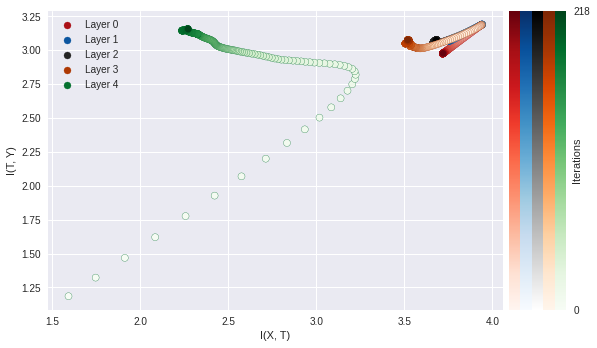

In [10]:
from matplotlib import pyplot as plt
from utils import moving_average
import numpy as np


Ixts, Itys = ip.getMutualInformation(moving_average_n=15)
colors=['Reds', 'Blues', 'binary', 'Oranges', 'Greens']

with plt.style.context('seaborn'):
    fig = plt.figure(constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.84, wspace=0.05)
    gs2 = fig.add_gridspec(nrows=1, ncols=len(Ixts), left=0.85, right=0.95, wspace=0)
    f8_ax1 = fig.add_subplot(gs1[:, :])
    f8_ax1.set_xlabel("I(X, T)")
    f8_ax1.set_ylabel("I(T, Y)")

    for idx, Ixt in enumerate(Ixts):
        Ity = Itys[idx]
        cmap = plt.cm.get_cmap(colors[idx])
        
        iterations = np.arange(len(Ixt))
        color = np.array([cmap(iterations[-1])])
        sc = f8_ax1.scatter(Ixt, Ity, c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
        f8_ax1.scatter([], [], c=color, label="Layer {}".format(idx))

        f8_ax2 = fig.add_subplot(gs2[0, idx])
        cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
        cb.set_ticks([])

    f8_ax1.legend()
    cb.set_ticks([0, iterations.max()])
    cb.set_label("Iterations", labelpad=-18)

    plt.show()

# Autoencoder

La optimización por *kernel aligment* no es posible para el caso de un autoencoder. En esos casos es más propio usar *Silverman’s rule of thumb*. Para kernels de alta dimensionalidad, propia de las vista en las redes neuronales, Nicolás I. Tapia et al. proponen una simplificación de este con una posible normalización teniendo en cuenta la dimensionalida. The *SilvermanOptimizer* is a implementation of this proposed method.

In [20]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.layer1 = nn.Sequential(
            # nn.Dropout(p=0.2),
            nn.Linear(784, 1024),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(1024),
            MatrixEstimator(0.1),
        )

        self.layer2 = nn.Sequential(
            # nn.Dropout(p=0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(256),
            MatrixEstimator(0.1),
        )
        
        self.layer3 = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(256, 64),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(64),
            MatrixEstimator(0.1),
        )

        self.layer4 = nn.Sequential(
            nn.Linear(64, 24),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(24),
            MatrixEstimator(0.1),
        )

        self.layer5 = nn.Sequential(
            nn.Linear(24, 64),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(64),
            MatrixEstimator(0.1),
        )

        self.layer6 = nn.Sequential(
            nn.Linear(64, 256),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(256),
            MatrixEstimator(0.1),
        )

        self.layer7 = nn.Sequential(
            nn.Linear(256, 1024),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(1024),
            MatrixEstimator(0.1),
        )
        self.layer8 = nn.Sequential(
            nn.Linear(1024, 784),
            nn.LeakyReLU(inplace=True),
            MatrixEstimator(12, requires_optim=False),
        )

        for m in self.modules():
            self.weight_init(m)

    def forward(self, x: Tensor) -> Tensor:
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        return x

    def weight_init(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight.data, nonlinearity='relu')

In [21]:
transformToTensor = Compose([
            ToTensor(), # first, convert image to PyTorch tensor
            Lambda(lambda x: torch.flatten(x)) # Auto-flatten
        ])

dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
train_set, val_set = torch.utils.data.random_split(dataset, [59488 , 512])
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)
eval_dataloader = DataLoader(val_set, batch_size=512, shuffle=False, num_workers=0)

In [22]:
import math
from IPDL.functional import matrix_estimator

val_inputs, val_targets = next(iter(eval_dataloader))
val_inputs = val_inputs.flatten(1).to(device)

n = val_inputs.size(0)
d = val_inputs.size(1) if len(val_inputs.shape) == 2 else reduce(lambda x, y: x*y, val_inputs.shape[1:])
gamma = 0.8
sigma = gamma * n ** (-1 / (4+d)) * math.sqrt(d) 

_, Ax = matrix_estimator(val_inputs, sigma=12)
Ax = Ax.to(device)

In [23]:
model = AutoEncoder().to(device)
model

AutoEncoder(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MatrixEstimator(sigma=0.10, requires_optim=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MatrixEstimator(sigma=0.10, requires_optim=True)
  )
  (layer3): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MatrixEstimator(sigma=0.10, requires_optim=True)
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=24

In [33]:
n_epoch = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.1)
matrix_optimizer = SilvermanOptimizer(model, gamma= .4, normalize_dim = True)

model.train()

eval_inputs, _ = next(iter(eval_dataloader))
eval_inputs = eval_inputs.to(device)

epoch_iterator = tqdm(
    range(n_epoch),
    leave=True,
    unit="epoch",
    postfix={"lss": "%.6f" % 0.0, "vls": "%.6f" % -1,},
)

ip = AutoEncoderInformationPlane(model)

for epoch in epoch_iterator:
    for idx, (inputs, _) in enumerate(train_dataloader):
        inputs = inputs.flatten(1).to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, inputs)
        loss_value = float(loss.item())        
        loss.backward()

        optimizer.step()

        if idx % 25 == 0:
            with torch.no_grad():
                model.eval()
                outputs = model(eval_inputs.flatten(1))
                eval_loss_value = float((criterion(outputs, eval_inputs.flatten(1))).item())
                epoch_iterator.set_postfix(
                    lss="%.6f" % loss_value, vls="%.6f" % eval_loss_value,
                )

            model.train()
    
    scheduler.step()
    
    matrix_optimizer.step()
    ip.computeMutualInformation(Ax)

100%|██████████| 10/10 [01:26<00:00,  8.61s/epoch, lss=0.044667, vls=0.042494]


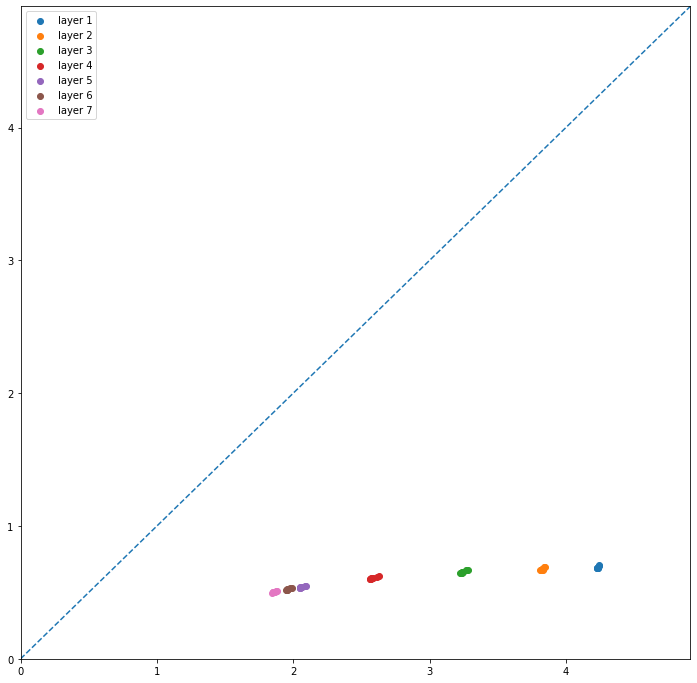

In [33]:
from matplotlib import pyplot as plt
from IPDL import MatrixBasedRenyisEntropy

f, ax = plt.subplots(figsize=(12, 12))
reference = MatrixBasedRenyisEntropy.entropy(Ax).cpu()
ax.set(xlim=(0, reference), ylim=(0, reference))

Ixt, Ity = ip.getMutualInformation(moving_average_n=3)

for idx in range(len(Ixt)):
    current_Ixt = Ixt[idx]
    current_Ity = Ity[idx]
    ax.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed')
plt.legend()
plt.show()

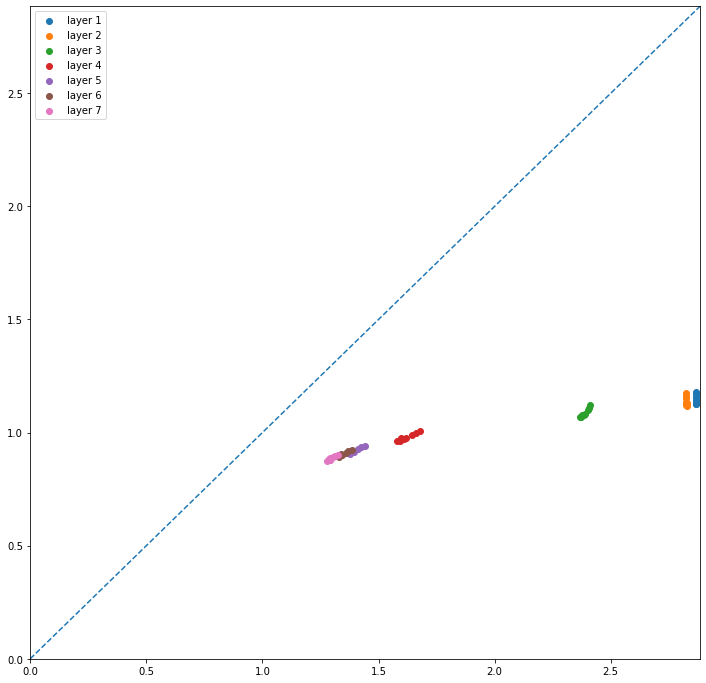

In [34]:
from matplotlib import pyplot as plt
from IPDL import MatrixBasedRenyisEntropy

f, ax = plt.subplots(figsize=(12, 12))
reference = MatrixBasedRenyisEntropy.entropy(Ax).cpu()
ax.set(xlim=(0, reference), ylim=(0, reference))

Ixt, Ity = ip.getMutualInformation(moving_average_n=3)

for idx in range(len(Ixt)):
    current_Ixt = Ixt[idx]
    current_Ity = Ity[idx]
    ax.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed')
plt.legend()
plt.show()

In [35]:
Ity[4]

array([0.91020934, 0.91894579, 0.90695   , 0.91257874, 0.91474883,
       0.92749993, 0.93505414, 0.94148906])

In [36]:
model

AutoEncoder(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MatrixEstimator(sigma=12.72, requires_optim=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MatrixEstimator(sigma=6.25, requires_optim=True)
  )
  (layer3): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MatrixEstimator(sigma=2.92, requires_optim=True)
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=2